In [1]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np
from IPython import display
import time
import pylab as pl

from fatenet.proto import fatenet_pb2
from pyfatenet import core, core_gradients, workspace
from pyfatenet.util import visualize, net_drawer, utils
from pyfatenet.model import cnn

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
ROOT_FOLDER = '/home/hy/Documents/fatenet_workspace/mnist/'
workspace.reset_workspace(ROOT_FOLDER)

model = cnn.CNNModelApi()

data, label = model.TensorProtosDBInput(
    [], ["data", "label"], batch_size=64,
    db="/home/hy/Documents/develop/data/mnist/mnist_train.minidb", db_type="minidb")
model.input(28)
model.kernel(1)

In [3]:
# load_net = core.Net('load')
# load_net.LoadTensor([], ['w1','b1','w2','b2','w3','b3','w4','b4'], db=ROOT_FOLDER + 'lenet100.minidb', db_type='minidb')
# plan = core.Plan("mnist_load")
# plan.add_nets([load_net])
# plan.add_step(core.ExecutionStep("load", load_net, 1))
# print str(plan.proto())

In [4]:
model.conv('data', 'conv1', 20, kernel=5, 
                   stride=1)
model.maxpool('conv1', 'pool1', kernel=2, stride=2)
model.conv('pool1', 'conv2', 50, kernel=5, 
                   stride=1)
model.maxpool('conv2', 'pool2', kernel=2, stride=2)
model.Flatten('pool2', "pool2_flatten")
model.fc('pool2_flatten', 'fc3', 500)
model.relu('fc3', 'fc3')
model.fc('fc3', 'fc4',10)
model.Softmax('fc4', 'pred')
model.LabelCrossEntropy(['pred', 'label'], 'xent')
model.AveragedLoss('xent', 'loss')

In [ ]:
load = core.create_operator('LoadTensor')([], ['iter'] + model.params, db=ROOT_FOLDER + 'lenet_snapshot_200', db_type='minidb')
workspace.run_operator_once(load)
print workspace.blobs()
print workspace.fetch_blob('iter')
print workspace.fetch_blob('conv1_w')
print workspace.fetch_blob('fc4_b')

# load = core.create_operator('LoadTensor')([], model.params, db=ROOT_FOLDER + 'lenet200.minidb', db_type='minidb')
# workspace.run_operator_once(load)
# print workspace.blobs()

# model.param_init_net.LoadTensor([], model.params, db=ROOT_FOLDER + 'lenet200.minidb', db_type='minidb')
# print workspace.blobs()

# accuracy = model.Accuracy(['pred', 'label'], "accuracy")
# # model.param_init_net.run_all_on_gpu()
# # model.net.run_all_on_gpu(use_cudnn=True)
# workspace.run_net_once(model.param_init_net.proto())
# workspace.create_net(model.net.proto())
# workspace.run_net(model.net.proto().name)

In [6]:
model.load(ROOT_FOLDER + 'lenet200.minidb')

In [7]:
#print model.proto()

CNN


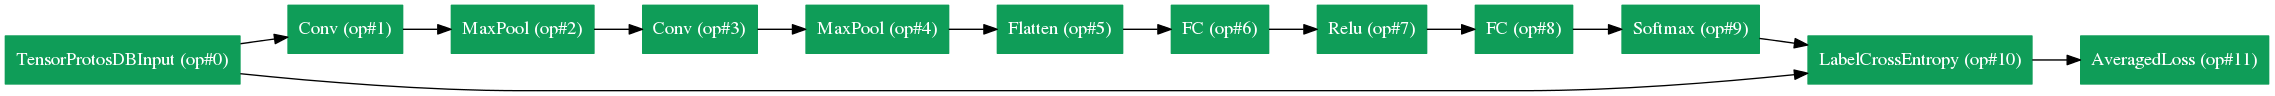

In [6]:
#graph = net_drawer.get_pydot_graph(model.net.proto().op, model.net.proto().name, rankdir='LR')
graph = net_drawer.get_pydot_graph_minimal(model.net.proto().op, model.net.proto().name, rankdir='LR')
print model.net.proto().name
display.Image(graph.create_png(), unconfined=True)

In [7]:
model.add_gradient_operators()
model.gradient_descent_optimize(-0.1)

accuracy = model.Accuracy(['pred', 'label'], "accuracy")

model.param_init_net.run_all_on_gpu()
model.net.run_all_on_gpu(use_cudnn=True)

# ITER = model.Iter([], 'iter')
# model.Snapshot([ITER] + model.params,
#                    db=ROOT_FOLDER + 'lenet_snapshot_%d',
#                    db_type="minidb", every=100)

In [8]:
plan = core.Plan("mnist_predict")
plan.add_nets([model.param_init_net, model.net])
plan.add_step(core.ExecutionStep("init", model.param_init_net, 1))
plan.add_step(core.ExecutionStep("predict", model.net, 1))
print str(plan.proto())

name: "mnist_predict"
network {
  name: "CNN_init"
  op {
    output: "conv1_w"
    name: ""
    type: "XavierFill"
    arg {
      name: "shape"
      ints: 20
      ints: 1
      ints: 5
      ints: 5
    }
  }
  op {
    output: "conv1_b"
    name: ""
    type: "ConstantFill"
    arg {
      name: "shape"
      ints: 20
    }
  }
  op {
    output: "conv2_w"
    name: ""
    type: "XavierFill"
    arg {
      name: "shape"
      ints: 50
      ints: 20
      ints: 5
      ints: 5
    }
  }
  op {
    output: "conv2_b"
    name: ""
    type: "ConstantFill"
    arg {
      name: "shape"
      ints: 50
    }
  }
  op {
    output: "fc3_w"
    name: ""
    type: "XavierFill"
    arg {
      name: "shape"
      ints: 500
      ints: 800
    }
  }
  op {
    output: "fc3_b"
    name: ""
    type: "ConstantFill"
    arg {
      name: "shape"
      ints: 500
    }
  }
  op {
    output: "fc4_w"
    name: ""
    type: "XavierFill"
    arg {
      name: "shape"
      ints: 10
      ints: 500


In [ ]:
workspace.run_net_once(model.param_init_net.proto())
workspace.create_net(model.net.proto())
workspace.run_net(model.net.proto().name)

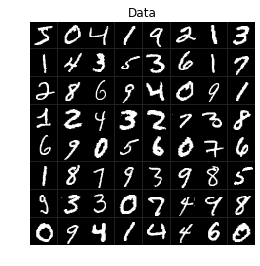

In [8]:
# Now, let's show some of the contents.
_ = visualize.NCHW.show_multiple(workspace.fetch_blob('data'))
pyplot.title('Data')

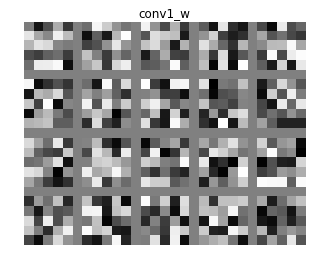

In [9]:
_ = visualize.NCHW.show_multiple(workspace.fetch_blob('conv1_w'))
pyplot.title('conv1_w')

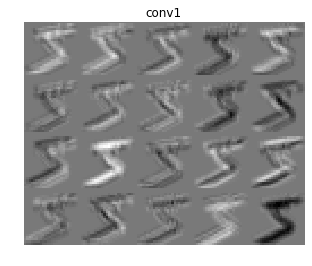

In [10]:
_ = visualize.NCHW.show_channels(workspace.fetch_blob('conv1')[0])
pyplot.title('conv1')

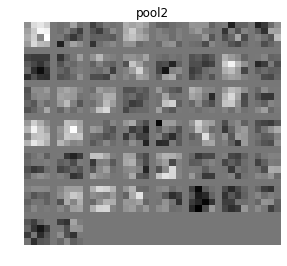

In [11]:
_ = visualize.NCHW.show_channels(workspace.fetch_blob('pool2')[0])
pyplot.title('pool2')

In [12]:
print workspace.fetch_blob('accuracy')

[ 0.171875]


[ 0.10665763  0.1051922   0.08072919  0.10870118  0.0944721   0.0633292
  0.14254929  0.13644618  0.08922173  0.07270139]


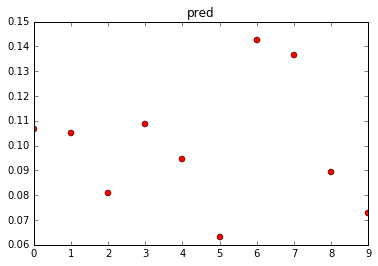

In [13]:
_ = pyplot.plot(workspace.fetch_blob('pred')[0].flatten(), "ro")
pyplot.title('pred')
print workspace.fetch_blob('pred')[0]

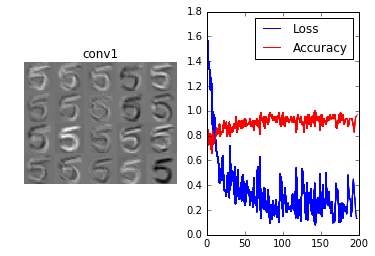

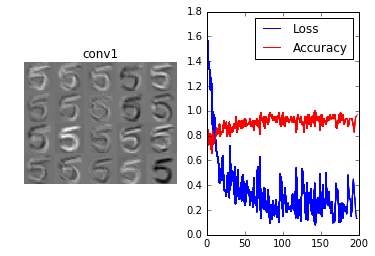

In [15]:
accuracy = np.zeros(200)
loss = np.zeros(200)
for i in range(200):
    
    
    pyplot.subplot(121)
    _ = visualize.NCHW.show_channels(workspace.fetch_blob('conv1')[0])
    
    pyplot.title('conv1')
    
    pyplot.subplot(122)
    pyplot.plot(loss[:i], 'b')
    pyplot.plot(accuracy[:i], 'r')
    pyplot.legend(('Loss', 'Accuracy'), loc='upper right')
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
#     time.sleep(1.0)
    
    workspace.run_net(model.net.proto().name)
    accuracy[i] = workspace.fetch_blob('accuracy')[0]
    loss[i] = workspace.fetch_blob('loss')
    if (i+1) % 100 == 0:
        save = core.create_operator('Save')(model.params, 'save', db='/home/hy/Documents/fatenet_workspace/mnist/lenet' +str(i+1) + '.minidb', db_type='minidb')
        workspace.run_operator_once(save)

# pyplot.plot(loss, 'b')
# pyplot.plot(accuracy, 'r')
# pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

In [ ]:
accuracy = np.zeros(200)
loss = np.zeros(200)
for i in range(200):
    workspace.run_net(model.net.proto().name)
    accuracy[i] = workspace.fetch_blob('accuracy')[0]
    loss[i] = workspace.fetch_blob('loss')
    if (i+1) % 100 == 0:
        save = core.create_operator('Save')(model.params, 'save', db='/home/hy/Documents/fatenet_workspace/mnist/lenet' +str(i+1) + '.minidb', db_type='minidb')
        workspace.run_operator_once(save)

pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

[  1.43618585e-04   4.76292241e-03   9.76923504e-04   1.07997730e-02
   2.47464981e-02   8.59929740e-01   6.46235887e-03   6.44348736e-04
   9.01494101e-02   1.38441450e-03]


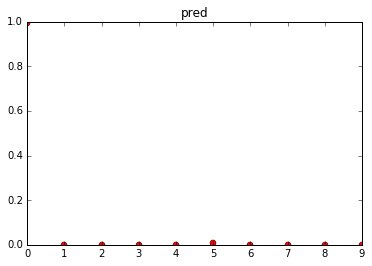

In [16]:
_ = pyplot.plot(workspace.fetch_blob('pred')[1].flatten(), "ro")
pyplot.title('pred')
print workspace.fetch_blob('pred')[0]

In [17]:
print workspace.fetch_blob('accuracy')

[ 0.9375]


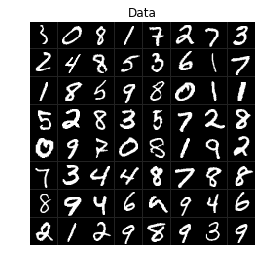

In [18]:
# Now, let's show some of the contents.
_ = visualize.NCHW.show_multiple(workspace.fetch_blob('data'))
pyplot.title('Data')